In [ ]:
import sys
sys.path.append("..")

import jax, os, corner
import jax.numpy as jnp
from jax import grad, config
import matplotlib.pyplot as plt
import numpy as np
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
from functools import partial

# Load reparameterization methods
from src.reparameterization import sigma, logistic_CDF, reparameterized_gradient

# Load birth/death method
from src.birth_death import birth_death

print(jax.devices())

# Mirrored Langevin Birth/Death

In [80]:
# Annealing schedule
gamma = lambda t: 1

def ula_kernel(key, param, log_post, grad_log_post, dt, iteration, lower, upper, stride=10):
    """ 
    Remarks
    -------
    
    (1) grad_log_post is the gradient of the potential. Change name of this later
    (2) stride = 1 will run birth-death at every iteration!
    
    """
    key, subkey = jax.random.split(key)

    # Transform to unbounded domain 
    Y, gmlpt_Y = reparameterized_gradient(param, grad_log_post, lower, upper, gamma(iteration))

    # Perform jumps in unbounded domain
    jumps = jax.lax.cond(jnp.mod(iteration, stride) == 0, lambda: birth_death(key, param, log_post, stepsize=jnp.min(dt), bandwidth=0.01, p=2, stride=stride, rate=1, a=lower, b=upper, gamma=gamma(iteration)), lambda: jnp.arange(param.shape[0]))

    # Perform update in unbounded domain
    Y = Y[jumps] - gmlpt_Y[jumps] * dt + jnp.sqrt(2 * dt) * jax.random.normal(key=subkey, shape=(param.shape))

    # Convert samples back to bounded domain 
    param = sigma(logistic_CDF(Y), lower, upper)

    iteration = iteration + 1

    return key, param, iteration

@partial(jax.jit, static_argnums=(1,2,3))
def ula_sampler_full_jax_jit(key, log_post, grad_log_post, n_iter, dt, x_0, lower, upper):

    # @progress_bar_scan(n_iter)
    # @scan_tqdm(1000)
    # @scan_tqdm(n_iter, print_rate=1, desc='progress bar', position=0, leave=False)
    def ula_step(carry, x):
        key, param, iteration = carry
        key, param, iteration = ula_kernel(key, param, log_post, grad_log_post, dt, iteration, lower, upper)
        return (key, param, iteration), param

    carry = (key, x_0, 0)
    _, samples = jax.lax.scan(ula_step, carry, None, n_iter)
    return samples

# Unit tests

In [81]:
def rejection_sampling(iid_samples, lower_bound, upper_bound):
    truth_table = ((iid_samples > lower_bound) & (iid_samples < upper_bound))
    idx = np.where(np.all(truth_table, axis=1))[0]
    print('%i samples obtained from rejection sampling' % idx.shape[0])
    return np.array(iid_samples[idx])

In [82]:
# 2-d mixture of Gaussians with increasing weights

from models.mog_new import MoG 

k = 3
d = 2
weights = jnp.array([2, 4, 5])

mus = jnp.zeros((k, d))
mus = mus.at[0].set(jnp.array([-10, 0]))
mus = mus.at[1].set(jnp.array([0, 0]))
mus = mus.at[2].set(jnp.array([10, 0]))

covs = jnp.zeros((k, d, d))
covs = covs.at[0].set(jnp.eye(d))
covs = covs.at[1].set(jnp.eye(d))
covs = covs.at[2].set(jnp.eye(d))

model = MoG(weights, mus, covs)

model.lower_bound = jnp.array([-15, -15])
model.upper_bound = jnp.array([15, 15])

iid_samples = model.newDrawFromPosterior(1000000)

bounded_iid_samples = rejection_sampling(iid_samples, model.lower_bound, model.upper_bound)

1000000 samples obtained from rejection sampling


In [97]:
# Setup and run sampler
n_iter = 1000
n_particles = 200
eps = 1e-3
X0 = model._newDrawFromPrior(n_particles)
key = jax.random.PRNGKey(0)
sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential), jax.vmap(jax.jacfwd(model.potential)), n_iter, eps, X0, model.lower_bound, model.upper_bound)

/home/al44828/miniconda3/envs/myenv5/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


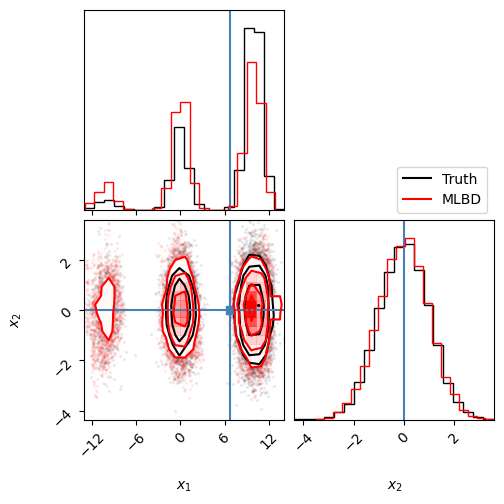

In [98]:
import matplotlib.lines as mlines
reshaped_matrix = np.array(sam.reshape((sam.shape[0] * sam.shape[1], sam.shape[2])))
fig = corner.corner(bounded_iid_samples[-20000:], hist_kwargs={'density':True}, truths=jnp.mean(bounded_iid_samples, axis=0), color='k') 
labels = [r'$x_1$', r'$x_2$']
k_line = mlines.Line2D([], [], color='k', label='Truth')
r_line = mlines.Line2D([], [], color='r', label='MLBD')
corner.corner(reshaped_matrix[-20000:], color='r', fig=fig, hist_kwargs={'density':True}, labels=labels)
plt.legend(handles=[k_line,r_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

In [ ]:
from models.gw150914 import gwfast_LVGW150914

# Initialize model
# model = gwfast_LVGW150914(wf_model='IMRPhenomD', nbins=100, verbose=True)
model = gwfast_LVGW150914(wf_model='TaylorF2', nbins=100, verbose=True)

# Center periodic coordinates 
for param in ['Phicoal', 'psi', 'phi']:
# for param in ['Phicoal', 'phi']:
    x = model.injParams[param][0]
    delta = x - (model.priorDict[param][1] + model.priorDict[param][0]) / 2
    model.priorDict[param][0] += delta
    model.priorDict[param][1] += delta

model.lower_bound = model.lower_bound.at[4].set(model.priorDict['phi'][0])
model.upper_bound = model.upper_bound.at[4].set(model.priorDict['phi'][1])

model.lower_bound = model.lower_bound.at[8].set(model.priorDict['Phicoal'][0])
model.upper_bound = model.upper_bound.at[8].set(model.priorDict['Phicoal'][1])

model.lower_bound = model.lower_bound.at[6].set(model.priorDict['psi'][0])
model.upper_bound = model.upper_bound.at[6].set(model.priorDict['psi'][1])

In [ ]:
model.lower_bound

In [ ]:
# Check to see if centering was successful
print(model.lower_bound)
print(model.upper_bound)

print(np.mean(np.array(model.priorDict['Phicoal'])))
print(model.true_params[8])

print(np.mean(np.array(model.priorDict['phi'])))
print(model.true_params[4])



In [ ]:

n_iter = 200000
n_particles = 200
# eps = 1e-6
eps = jnp.ones(9) * 1e-7
eps = eps.at[1].set(1e-5)


subset_params = jnp.array([0, 1, 2, 3, 5, 6, 7, 9, 10])
lower = model.lower_bound[subset_params] 
upper = model.upper_bound[subset_params]

# injection wrapper
DoF = len(model.gwfast_param_order)
injection = np.zeros(DoF)
for d in range(DoF):
    injection[d] = model.injParams[model.gwfast_param_order[d]]

X_injection = np.tile(injection, n_particles).reshape(n_particles, DoF)
X_injection_gpu = jnp.array(X_injection)

# Initial draw from reduced prior
X0_all = model._newDrawFromPrior(n_particles)
X0_subset = X0_all[:, subset_params]

# Fix eta coordinate for testing!
# X0_subset = X0_subset.at[:,1].set(jnp.ones(n_particles) * injection[1])

def potential_subset(X_red):
    X_ = X_injection_gpu.at[:, subset_params].set(X_red)
    return model.minusLogLikelihood(X_)

def gradient_subset(X_red):
    X_ = X_injection_gpu.at[:, subset_params].set(X_red)
    return model.gradient_minusLogLikelihood(X_)[:, subset_params]
    


In [ ]:
import matplotlib.pyplot as plt
n_iter = 100000
plt.plot(np.arange(n_iter), gamma(np.arange(n_iter), T=n_iter, c=3, p=5))

In [ ]:
from jax_tqdm import scan_tqdm

In [ ]:
# Settings for run
n_iter = 100000

# n_iter = 100
n_particles = 200
eps = 1e-6

X0 = model._newDrawFromPrior(n_particles)
key = jax.random.PRNGKey(0)
# eps = jnp.ones(11) * 5e-7
# eps = eps.at[1].set(5e-5)
# eps = eps.at[4].set(1e-4)
# eps = eps.at[8].set(1e-4)

# For mixture of Gaussian model
# sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential), jax.vmap(jax.jacfwd(model.potential)), n_iter, eps, X0)

# For subset
# sam = ula_sampler_full_jax_jit(key, potential_subset, gradient_subset, n_iter, eps, X0_subset)

# For whole damn thing


sam = ula_sampler_full_jax_jit(key, model.minusLogLikelihood, model.gradient_minusLogLikelihood, n_iter, eps, X0, model.lower_bound, model.upper_bound)

In [ ]:
reshaped_matrix = np.array(sam.reshape((sam.shape[0] * sam.shape[1], 11)))
fig = corner.corner(reshaped_matrix[-50000:], hist_kwargs={'density':True}, labels=model.gwfast_param_order, truths=model.true_params)

In [ ]:
sam = ula_sampler_full_jax_jit(key, model.minusLogLikelihood, model.gradient_minusLogLikelihood, n_iter, eps, sam[-1], model.lower_bound, model.upper_bound)

In [ ]:
# Draw several particles from prior
X = model._newDrawFromPrior(3)

# Francesco derivative
test1 = model.gradient_minusLogLikelihood(X)

# Take gradient of likelihood directly
# f = jax.jit(jax.jacfwd(model.minusLogLikelihood))
# gl = jax.jacobian(model.minusLogLikelihood)

# Check to see if this works
# gl(X[0].squeeze())

# f = jax.vmap(jax.jacfwd(model.minusLogLikelihood))
# f(X)
# model.gradient_minusLogLikelihood(X)

In [ ]:
test1

In [ ]:
np.allclose(test2[np.arange(3), np.arange(3), :], test1)

In [ ]:
test2 = f(X)

In [ ]:
a.shape

In [ ]:
print(model.gwfast_param_order)

In [ ]:
sam.shape

In [ ]:
reshaped_matrix = np.array(sam.reshape((sam.shape[0] * sam.shape[1], 11)))
fig = corner.corner(reshaped_matrix[-50000:], hist_kwargs={'density':True}, labels=model.gwfast_param_order, truths=model.true_params)

In [ ]:
sam = ula_sampler_full_jax_jit(key, potential_subset, gradient_subset, n_iter, eps, sam[-1])

In [ ]:
reshaped_matrix = np.array(sam.reshape((n_iter * n_particles, len(subset_params))))
labels = np.array(model.gwfast_param_order)[subset_params]
fig = corner.corner(reshaped_matrix[-50000:], hist_kwargs={'density':True}, labels=labels, truths=injection[subset_params])

In [ ]:
import corner
reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))
reshaped_matrix = np.array(reshaped_matrix)
fig = corner.corner(reshaped_matrix[-20000:], hist_kwargs={'density':True}, truths=jnp.mean(bounded_iid_samples, axis=0)) # For rosenbrock
# fig = corner.corner(np.array(reshaped_matrix[-60000:]), hist_kwargs={'density':True}, truths=jnp.mean(bounded_iid_samples, axis=0)) # For rosenbrock
corner.corner(bounded_iid_samples[-20000:], color='r', fig=fig, hist_kwargs={'density':True})


# GW PROBLEM